In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Comparison with analytical solution

1. Formulas for the analytical solution.

2. Parameters of the simulation.

3. Read results and compare



## 1. Formulas for the analytical solutoin

For an initial condition $\zeta(r,0) = 2 e^{-(r/a)^2}$, $\zeta_t(r,0) = 0$, the analytical solution of Carrier (1991) according to Cho (1995) is

$$\zeta(r,t) = \int_0 ^ \infty a^2 e^{-(ak)^2}k cos \left( 
\frac{\sqrt{gh}kt}{1+\frac{(kh)^2}{3}}\right)
J_0 (kr)
dk$$

Introducing the following dimensionless variables:

$$h' = \frac{h}{a}$$
$$ x' = \frac{x}{a}$$
$$ y' = \frac{y}{a}$$
$$ k' = ak$$
$$ t' = \frac{\sqrt{gh}}{a}t $$

the analytical solution becomes

$$\zeta(r,t) = \int_0 ^\infty k' e^{-(k')^2/4} \cos\left(
\frac{k't'}{\sqrt{1+\frac{(k'h')^2}{3}}}\right)
J_0(k'r') dk'
$$

In [2]:
from scipy.special import j0
from scipy.integrate import quad, quadrature, romberg

The following is to compute the integral as a limit of riemann sums

In [3]:
def integrand(k,r,t,h):
    return k*np.exp(-k*k*0.25)*np.cos(k*t/np.sqrt(1+(k*h)*(k*h)/3.))*j0(k*r)

def integral(k,r,t,h,dk):
    return np.sum(integrand(k,r,t,h)*dk)

def iterate_dk(r,t,h,itdk,kmax):
    dk = 2**(-itdk)
    k = np.arange(0,kmax,dk)    
    this_integral = integral(k,r,t,h,dk)
    return this_integral

def iterate_kmax(r,t,h,ndk,kmax,toldk,verb=False):
    
    integral_dk = np.zeros(ndk)
    
    integral_dk[0] = iterate_dk(r,t,h,0,kmax)    
    for itdk in range(1,ndk):    
        this_integral = iterate_dk(r,t,h,itdk,kmax)
        integral_dk[itdk] = this_integral
        err = np.abs(this_integral-integral_dk[itdk-1])
        if verb: print('\tIn dk (itdk,err) = ',itdk,',',err)
        if err < toldk:            
            return this_integral
    raise ValueError('something went wrong in dk loop: err=',err)

def solution(r, t, h, ndk=100, nkmax=30, toldk = 1e-15, tolkmax = 1e-15, verb=False): 
    ndk = 100
    nkmax = 20*3
    toldk = 1e-5
    tolkmax = 1e-5
    integral_kmax = np.zeros(nkmax)
    integral_kmax[0] = iterate_kmax(r,t,h,ndk,1,toldk)
    for itkmax,kmax in enumerate(range(2,nkmax)):
        integral_kmax[itkmax] = iterate_kmax(r,t,h,ndk,kmax,toldk,verb=verb)

        err = np.abs(integral_kmax[itkmax]-integral_kmax[itkmax-1])
        if verb: print('\nIn kmax (itkmax,err) =',itkmax,err)
        if err<tolkmax:
            return integral_kmax[itkmax]
    raise ValueError(' something went wrong in kmax loop: err=',err)

This was necessary because the integrand is really oscillatory

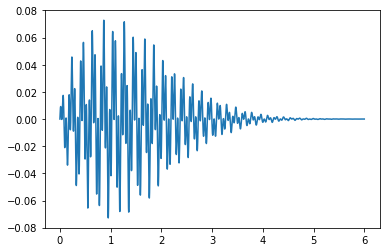

In [4]:
k =  np.linspace(0,6,100000)
plt.plot(k,integrand(k,r=70,t=40,h=0.2))

For an example case:

In [5]:
r = np.linspace(20,70,500)
zeta_t40 = np.vectorize(solution)(r,t=40,h=0.2)
zeta_t50 = np.vectorize(solution)(r,t=50,h=0.2)
zeta_t60 = np.vectorize(solution)(r,t=60,h=0.2)

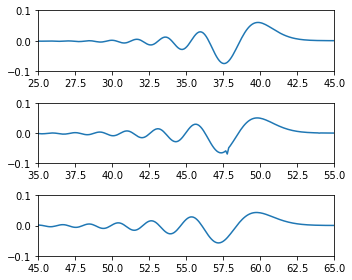

In [6]:
plt.subplot(311)
plt.plot(r,zeta_t40)
plt.xlim(25,45)
plt.ylim(-0.1,0.1)

plt.subplot(312)
plt.plot(r,zeta_t50)
plt.xlim(35,55)
plt.ylim(-0.1,0.1)

plt.subplot(313)
plt.plot(r,zeta_t60)
plt.xlim(45,65)
plt.ylim(-0.1,0.1)

plt.gcf().set_size_inches(5,4)
plt.tight_layout()
# plt.xlim(30,60)

## 2. Parameters of the simulations

### Case 1:

* $h = 0.2$
* $\Delta x = 0.5$
* $n_x = 280$
* $\Delta t = \Delta t' / \sqrt{gh}$
* $\Delta t' = 0.3 $
* $T_{final}' = 40$

This leads to $CFL = \frac{\Delta t}{\Delta x} \sqrt{gh} = \frac{\Delta t'}{\Delta x} = 0.6$

In [31]:
h = 0.2
dx = 0.5
nx = 280
dt_adim = 0.3
dt_dim = dt_adim*np.sqrt(9.81*h) # t*sqrt(t)
print('dimensional time step \t= {}'.format(dt_dim))
print('Imamura time step, dt \t= {}'.format(np.sqrt(dx*dx-4*h*h)/np.sqrt(9.81*h)))

dimensional time step 	= 0.4202142310774351
Imamura time step, dt 	= 0.2141764684390596


This means Case 1 is more oscillatory

### Case 2:
Same but half timestep $\Delta t' = 0.15$.

This case has just the right Imamura discretization

### Case 3:
Half timestep than before, $\Delta t' = 0.075$

This case is below Imamura's criteria

* Build the mesh:

In [8]:
x = y = np.linspace(-nx/2*dx, nx/2*dx, nx)
x,y = np.meshgrid(x,y)
rnum = np.sqrt(x*x+y*y)

Function to get slices of gridded data

In [9]:
def interpolate_profile(x, y, z, theta = 0, rmax=65, npoints=400):
    from scipy.interpolate import RectBivariateSpline

    rnum = np.linspace(-rmax, rmax, npoints)
    xnum, ynum = rnum*np.cos(theta), rnum*np.sin(theta)

    interpolate = RectBivariateSpline(x[0,:],y[:,0],z[:,:])

    zinterp = interpolate.ev(xnum,ynum)
    
    return rnum, zinterp

## 3. Simulation results

### Case $\Delta t' = 0.3$, $\Delta x = 2 \Delta x^*$

0


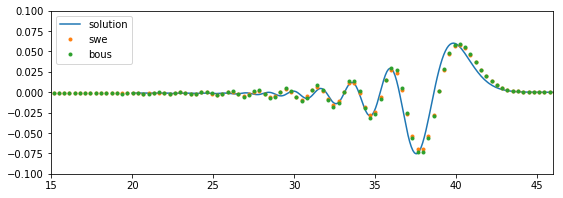

45


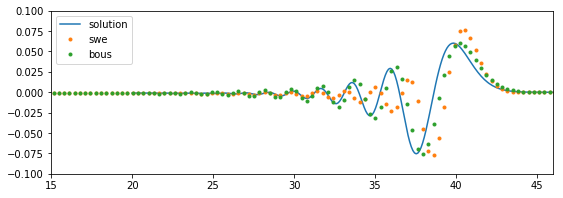

90


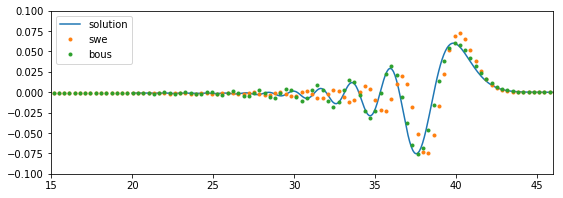

In [32]:
zswe = np.loadtxt('../tsunamilab/tlab2D',delimiter=',',skiprows=1).reshape((nx,nx))
zbous = np.loadtxt('../tsunamilab/tlab2D_d',delimiter=',',skiprows=1).reshape((nx,nx))

for theta in [0, 45, 90]:
    rswei, zswei = interpolate_profile(x,y, zswe, theta=theta)
    rbousi, zbousi = interpolate_profile(x,y, zbous, theta=theta)

    plt.plot(r,zeta_t40, label='solution')
    plt.plot(rswei, zswei,'.', label='swe')
    plt.plot(rbousi, zbousi,'.', label='bous')
    plt.legend()
    plt.xlim(15,46)
    plt.ylim(-0.1,0.1)
    plt.gcf().set_size_inches(9,3)
    print(theta)
    plt.show()

### Case $\Delta t' = 0.15$ ($\Delta x = \Delta x^*$)

0


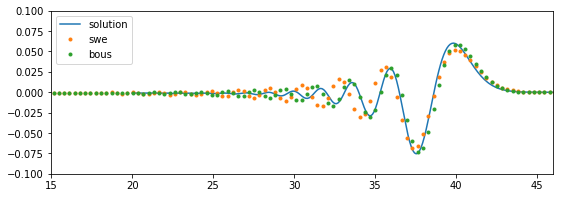

45


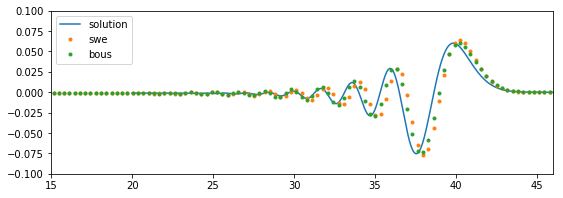

90


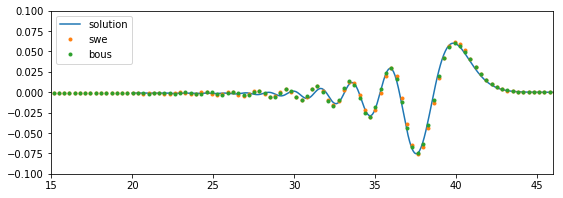

In [33]:
zswe = np.loadtxt('../tsunamilab/tlab2D_2',delimiter=',',skiprows=1).reshape((nx,nx))
zbous = np.loadtxt('../tsunamilab/tlab2D_d_2',delimiter=',',skiprows=1).reshape((nx,nx))

for theta in [0, 45, 90]:
    rswei, zswei = interpolate_profile(x,y, zswe, theta=theta)
    rbousi, zbousi = interpolate_profile(x,y, zbous, theta=theta)

    plt.plot(r,zeta_t40, label='solution')
    plt.plot(rswei, zswei,'.', label='swe')
    plt.plot(rbousi, zbousi,'.', label='bous')
    plt.legend()
    plt.xlim(15,46)
    plt.ylim(-0.1,0.1)
    plt.gcf().set_size_inches(9,3)
    print(theta)
    plt.show()

### Case $\Delta t' = 0.075$, $\Delta x = 0.5 \Delta x^*$

0


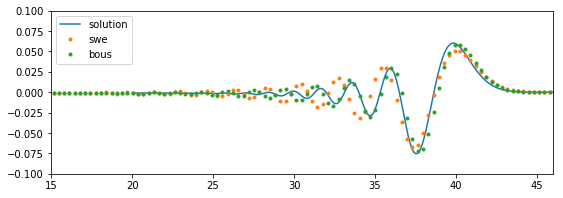

45


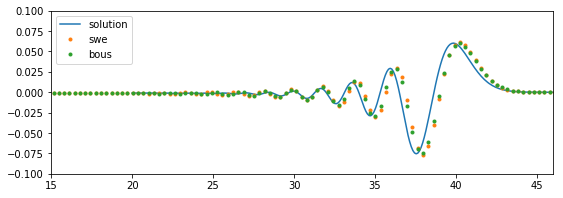

90


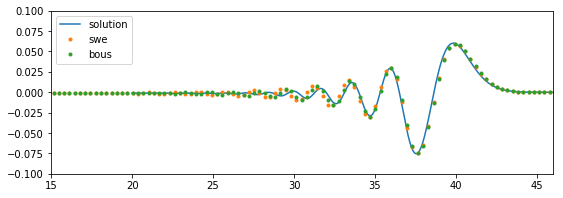

In [34]:
zswe = np.loadtxt('../tsunamilab/tlab2D_3',delimiter=',',skiprows=1).reshape((nx,nx))
zbous = np.loadtxt('../tsunamilab/tlab2D_d_3',delimiter=',',skiprows=1).reshape((nx,nx))

for theta in [0, 45, 90]:
    rswei, zswei = interpolate_profile(x,y, zswe, theta=theta)
    rbousi, zbousi = interpolate_profile(x,y, zbous, theta=theta)

    plt.plot(r,zeta_t40, label='solution')
    plt.plot(rswei, zswei,'.', label='swe')
    plt.plot(rbousi, zbousi,'.', label='bous')
    plt.legend()
    plt.xlim(15,46)
    plt.ylim(-0.1,0.1)
    plt.gcf().set_size_inches(9,3)
    print(theta)
    plt.show()